# 프로젝트: 스티커 만들기

* 얼굴에서 눈, 코, 입 등의 위치를 어떻게 알 수 있을까? 얼굴의 특징점인 Landmark를 N개 찾아내어 해당 위치에 스티커를 적용해볼 수 있다. 

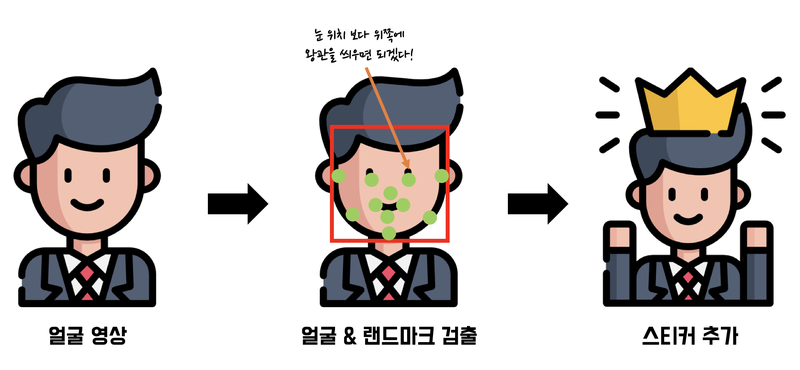

In [73]:
# !pip install dlib

In [74]:
# !pip install opencv-python

In [75]:
# 기본적으로 사용하는 라이브러리 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## 1. 얼굴 이미지와 스티커 불러오기 

### 라이브러리에 맞는 이미지 채널

#### 왜 BGR?
* Opencv 라이브러리에서 이미지 형식의 표준?(default?)는 BGR이다. RGB와 반대로 BGR은 Blue, Green, Red를 의미한다. 영상기기에서 초기에 개발자들이 BGR을 사용했는데 그 이유는 CPU 제조사에 따라 값을 오->왼쪽으로 읽는지, 왼->오른쪽으로 읽는지에 대한 범용성 때문이다. 그래서 BGR로 쓰면 값이 (255, 0, 0)인 RGB도 BGR로는 오른쪽 자리부터 채워져서 값이 어느 쪽으로 읽히든지 잘 반영될 수 있다. 

* 관련 링크: https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/

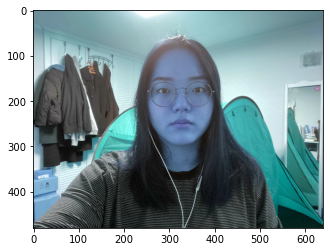

In [76]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

#### 왜 다시 RGB?
* 최근 라이브러리들은 이미지 채널을 RGB로 사용한다. 그래서 RGB 형태로 바꿔줘야한다. 이는 opencv를 써도 되고  reshape을 해줘도 된다. 

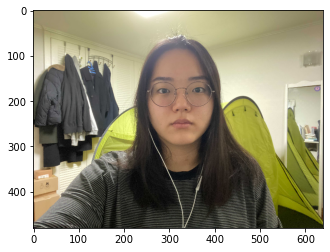

In [77]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 검출 & 랜드마크 검출 하기


### Dlib 활용한 hog detector 사용하기
* num of img pyramid? 이미지를 upsampling 방법으로 크기를 키우는 것, 이미지 피라미드에서 얼굴을 검출하면 작게 촬영된 얼굴 이미지를 크게 볼 수 있어 검출의 정확도를 높일 수 있다. 

In [78]:
import dlib

detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

rectangles[[(253, 133) (408, 288)]]


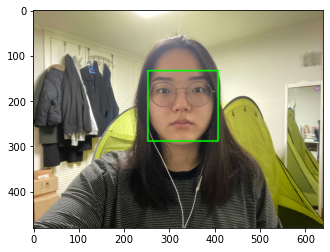

In [79]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 스티커 적용 위치 확인하기


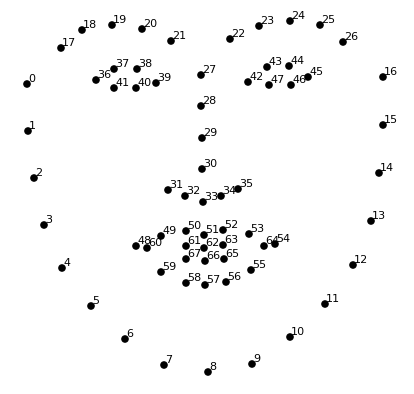

### Object keypoint estimation 알고리즘 
* 객체 내부의 Landmark와 같은 점을 찾는 알고리즘을 일컫는다. bbox(bounding box)를 찾고 box 내부의 keypoint를 예측하는 top-down 
* 이미지 전체의  keypoint를 먼저 찾고 point 관계를 이용해 군집화해서 bbox 생성하는 bottom-up 있다. 

* 지정한 모델을 불러오기 

In [80]:
import os 

model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [81]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]),'개')

68 개


* 문제점: 얼굴 검출 영역이 턱밑쪽으로 잡히면서 랜드마크 오차도 큰 것을 알 수 있다.

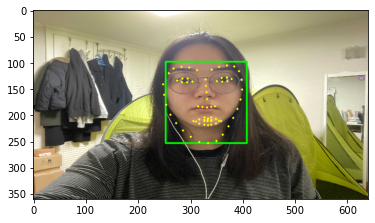

* 해결: 원인은 이미지의 Resize 때문이었다. 이미지의 비율과 다르게 눌러진채로 Resize하다보니 얼굴 인식에 오차가 커진 것이었다. 
    - 기존 640*360에서 일반적인 사진 비율인 640*480으로 수정했다.

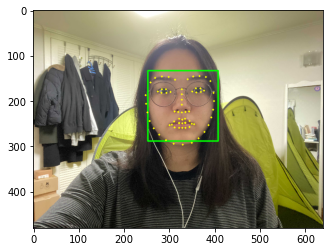

In [82]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 스티커 적용하기
 

* 적용하고자 하는 이미지는 수염이다. 따라서 코끝점에 해당하는 34번째 점을 활용한다.

In [83]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose index : 33
    x = landmark[33][0]
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(328, 225)
(x,y) : (328,225)
(w,h) : (156,156)


* 이때 스티커는 정사각형꼴에 수염이 중앙에 위치한 사진이어야한다. 

(156, 156, 3)


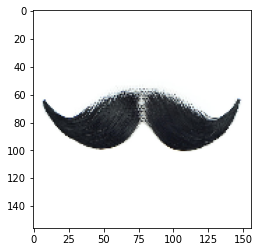

In [85]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/test.jpg'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

img_sticker_show =  cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_show)
plt.show()

* 아래 이미지에 박스에 해당하는 위치를 지정해줘야한다.

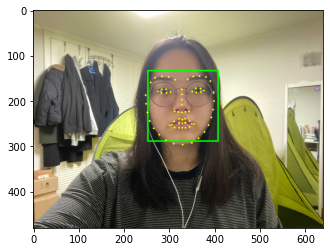

* refine 후에 반올림으로 인한 사이즈 차이 오류를 방지해야한다. 

```
    x = landmark[33][0]
    y = landmark[33][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
```

In [86]:
left_x = x - w // 2  # left
top_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(left_x, top_y))

(x,y) : (250,147)


In [87]:
img_sticker.shape

(156, 156, 3)

In [88]:
sticker_area = img_show[top_y:top_y+img_sticker.shape[0], left_x:left_x+img_sticker.shape[1]]

* 에러: 슬라이싱으로 범위를 설정해줄때 refine으로 왼쪽 상단의 박스 꼭지점을 찾아줘야하는데 이 부분에 대한 해결을 못 했다. 

In [89]:
img_show[top_y:top_y+img_sticker.shape[0], left_x:left_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

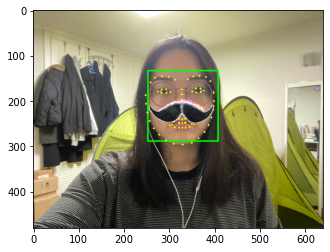

In [90]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [91]:
sticker_area = img_bgr[top_y:top_y+img_sticker.shape[0], left_x:left_x+img_sticker.shape[1]]
img_bgr[top_y:top_y+img_sticker.shape[0], left_x:left_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

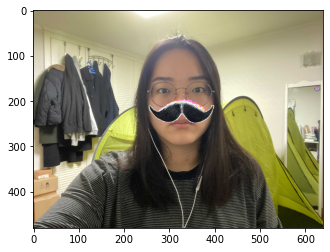

In [92]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 문제점 해결하기

* 개발환경 관련 오류 
    - (Problem) dlib이 설치가 안 되는 현상이 나타났다. dlib를 설치하기 위해선 cmake 라이브러리가 잘 설치되어있어야하는데, cmake가 수동으로 설치해줘도 그리고 pip/ conda로 모두 설치는 되지만 버전 충돌인지 실행되지 않았다. 
        - (Solution) Anaconda3 완전 삭제 후 재설치: Anaconda3 완전 삭제하기위해선 터미널창에서 아래와 같은 코드 실행 후 bashrc 파일을 열어 conda initialization 부분을 삭제해주면 완전히 삭제된다.  
    ```
    !conda install anaconda-clean
    !anaconda-clean --yes 
    !rm -rf /anaconda3 
    !rm -rf ~/.anaconda3_backup
    !sudo vi ./bashrc 
    ```

## 6. 루브릭 및 회고 

### 6.1. 루브릭

* 원본에 스티커 적용이나, 좌표계산은 인덱싱, 슬라이싱 개념을 활용해서 수월하게 진행했다.
* 생각보다 좌표를 수정하고 하는 과정은 쉬웠는데 입력 이미지에 대한 부분이 어려웠다. 실제로 여러 이미지를 시도했을때 얼굴 검출이 안되는 사진들이 있었다. 여러 사진을 시도해본 결과 다음과 같은 사진들은 얼굴 검출이 어려웠다.
    - 캐릭터 이미지
    - 필터 카메라가 심하게 적용된 이미지
    - 얼굴과 목간에 밝기 구분이 적은 이미지

### 6.2. 회고


* 노트북 고장으로 과제를 새로 다시하면서 백업의 중요성을 느꼈다. 
* 이미지 매핑하는 방식으로 말고 레이어를 여러개로 하는 진짜? 합성하는 것도 해보고 싶다는 생각이 들었다. 
* 추후 얼굴 인식 관련 프로젝트를 할 때 참고하기 좋은 토이 프로젝트였다. 